# Deep learning
---------------------------

This example shows how we can use ATOM to train and validate a Convolutional Neural Network implemented using [Keras](https://keras.io/).

Import the MNIST dataset from [keras.datasets](https://keras.io/api/datasets/mnist/). This is a well known image dataset with handwritten digits.

## Load the data

In [1]:
# Disable annoying tf warnings
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR)

# Import standard packages
from atom import ATOMClassifier, ATOMModel
from skopt.space.space import Integer, Categorical

# Keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
# Create the convolutional neural network
def neural_network():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=3, activation="relu"))
    model.add(Flatten())
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Since ATOM uses sklearn's API, use Keras' wrapper
model = KerasClassifier(neural_network, epochs=1, batch_size=512, verbose=0)

# Convert the model to an ATOM model
model = ATOMModel(model, acronym='NN', fullname='Neural network')
model.type = 'gradient'

In [3]:
# Download the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
# Reshape data to fit model
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

## Run the pipeline

In [5]:
atom = ATOMClassifier((X_train, y_train), (X_test, y_test), n_rows=0.1, n_jobs=4, warnings=False, verbose=2)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ================== >>
Shape: (7000, 2)
Categorical columns: 1
Scaled: False
-----------------------------------
Train set size: 6000
Test set size: 1000
-----------------------------------
Train set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.1:1.3:1.1:1.2:1.2:1.0:1.2:1.2:1.2:1.1
Test set balance: 0:1:2:3:4:5:6:7:8:9 <==> 1.3:1.5:1.1:1.4:1.0:1.1:1.3:1.4:1.0:1.2
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |       692 |     587 |    105 |
|  1 |       795 |     676 |    119 |
|  2 |       668 |     578 |     90 |
|  3 |       708 |     596 |    112 |
|  4 |       683 |     601 |     82 |
|  5 |       606 |     518 |     88 |
|  6 |       708 |     602 |    106 |
|  7 |       750 |     638 |    112 |
|  8 |       702 |     616 |     86 |
|  9 |       688 |     5

In [6]:
# When the input data has more than 2 dimensions, ATOM creates a 
# dataset with just one column of shape (n_samples, shape_sample)
print(atom.dataset.head())
print(f"\nEvery row in the column contains the data of one image, with shape: {atom.dataset.iloc[0, 0].shape}")

                                            Features  target
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
1  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       6
2  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       3
3  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       0
4  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...       2

Every row in the column contains the data of one image, with shape: (28, 28, 1)


In [7]:
# Like any other model, we can define custom dimensions for the bayesian optimization
dim = [Integer(1, 3, name="epochs"), Categorical([32, 64, 128, 256], name="batch_size")]

atom.run(model, metric="f1_weighted", n_calls=5, bo_params={"dimensions": dim, "cv": 1, "max_time": 120})


Training ===================================== >>
Models: NN
Metric: f1_weighted


Running BO for Neural network...
Initial point 1 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 32}
Evaluation --> f1_weighted: 0.9442  Best f1_weighted: 0.9442
Time iteration: 10.107s   Total time: 10.111s
Initial point 2 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 64}
Evaluation --> f1_weighted: 0.9641  Best f1_weighted: 0.9641
Time iteration: 13.018s   Total time: 23.145s
Initial point 3 ---------------------------------
Parameters --> {'epochs': 3, 'batch_size': 256}
Evaluation --> f1_weighted: 0.9292  Best f1_weighted: 0.9641
Time iteration: 11.667s   Total time: 34.812s
Initial point 4 ---------------------------------
Parameters --> {'epochs': 2, 'batch_size': 128}
Evaluation --> f1_weighted: 0.9501  Best f1_weighted: 0.9641
Time iteration: 8.483s   Total time: 43.295s
Initial point 5 ---------------------------------
Parameters --> {

## Analyze the results

In [8]:
# We can use the prediction methods like any other model
atom.nn.predict_proba(X_train)

array([[2.7833973e-08, 1.5802347e-11, 5.8050437e-10, ..., 3.8111640e-08,
        2.8912558e-07, 2.6020126e-07],
       [1.0000000e+00, 1.9997780e-13, 1.2452290e-09, ..., 4.2151291e-12,
        5.4967320e-10, 9.7510311e-10],
       [7.5203090e-12, 1.4871786e-10, 2.5926665e-08, ..., 4.2381049e-10,
        5.5594995e-08, 4.7841951e-08],
       ...,
       [7.4033468e-09, 2.5506302e-09, 3.5281917e-14, ..., 1.5363735e-12,
        1.5984324e-06, 7.9814981e-08],
       [5.2521988e-05, 2.3345517e-10, 1.1258288e-08, ..., 2.5015936e-08,
        1.8707331e-11, 8.5959512e-12],
       [1.2556100e-05, 1.3853971e-06, 3.1533356e-05, ..., 2.3861492e-05,
        9.9365270e-01, 6.2594912e-03]], dtype=float32)

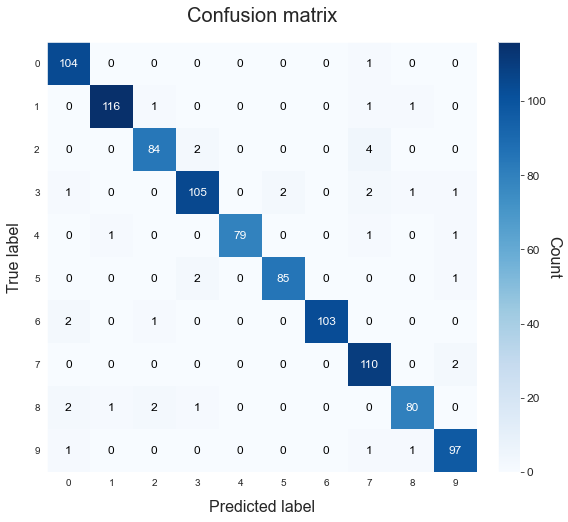

In [9]:
# Or make plots...
atom.nn.plot_confusion_matrix()